# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Remarks`: Yeyyyyy panalo raw toh sa Sensiitivity Analysis

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


`Note`: Implementation is taken from [Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification)

## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python tqdm seaborn scikit-learn
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

`Note`: Starting now, we will be using our own dataset to train the model

In [1]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections 
import os
import time

import imageio
import shutil
import cv2
import mediapipe as mp
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers

2024-12-13 00:14:47.417680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734020091.437181   72641 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734020091.901327   72641 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 00:14:56.220585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Limit usage of VRAM to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_virtual_device_configuration(gpu,
                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5820)])

`Note`: Ikaw bahala sa pag lagay ng memory limit, check your gpu specs and refer to that specs when changing.

#### Visualize the data first

In [4]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [12]:
## Define the dimensions of frames in the set of frames created (Default params muna)
HEIGHT = 224
WIDTH = 224
SEQUENCE_LENGTH = 20 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang.
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress', 'Idle'
          ]) # Eto muna

- `Note`: This can be changed later on once model is okay

In [6]:
def balance_dataset_before_split(dataset_dir):
    """
    Balance the number of files in each folder before splitting by randomly deleting excess files
    to match the lowest count.
    """
    print("\nBalancing dataset...")
    dataset_dir = pathlib.Path(dataset_dir)

    # Get all class subdirectories
    class_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
    
    # Count the number of files in each class directory
    file_counts = {class_dir: len(list(class_dir.iterdir())) for class_dir in class_dirs}
    
    # Find the lowest file count
    lowest_count = min(file_counts.values())
    
    print(f"Lowest file count across classes: {lowest_count}")

    # Balance each class directory
    for class_dir, count in file_counts.items():
        if count > lowest_count:
            excess_files = random.sample(list(class_dir.iterdir()), count - lowest_count)
            for file in tqdm(excess_files, desc=f"Balancing {class_dir.name}", unit="file"):
                file.unlink()

def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Balance the dataset before splitting
    balance_dataset_before_split(dataset_dir)

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]
    
    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(video_files)
        
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test 
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to directories (train, val, test)
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [7]:
## File path
file_path = './PD_dataset/' 

In [8]:
## Split the dataset, if na-run na ng isang beses wag na i-run ule, dahil sa code na hindi pa naayos, mawawala lahat yan since na split na si dataset
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS) 

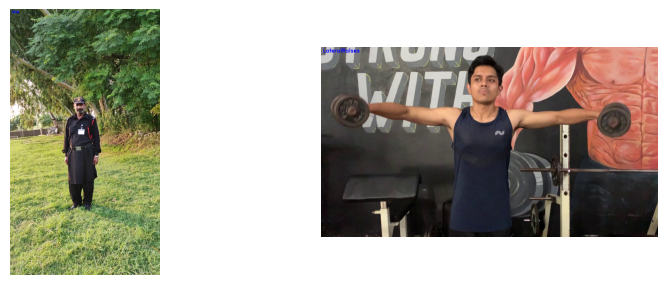

In [9]:
visulize_data(file_path + 'train/')

In [10]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Create Frames from each video

In [11]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  frame = (frame - 0.5) / 0.5  # Adjust to range [-1, 1], to normalize the frame
  return frame

In [12]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224)):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, video_length // n_frames)

    if video_length <= n_frames:
        start = 0
    else:
        max_start = video_length - n_frames * frame_step
        start = random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [17]:
def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = tf.image.random_flip_left_right(frame)
        frame = tf.image.random_brightness(frame, max_delta=0.2)
        frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
        frame = tf.image.random_saturation(frame, lower=0.8, upper=1.2)
        augmented_frames.append(frame)
    return tf.stack(augmented_frames)

In [18]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False, augment=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.augment = augment
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi')) + list(self.path.glob('*/*.mov')) + list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames, output_size=(HEIGHT, WIDTH))
            if self.augment and self.training:
                video_frames = augment_frames(video_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [19]:
## Pinagsama na yung framgen at output signature 
def configure_dataset(dataset_path, n_frames, batch_size=2, training=False, augment=False):
    frame_gen = FrameGenerator(dataset_path, n_frames, training=training, augment=augment)
    output_signature = (
        tf.TensorSpec(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    ds = tf.data.Dataset.from_generator(frame_gen, output_signature=output_signature)
    if training:
        ds = ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

#### Split and Generate the datasets

In [20]:
train_ds = configure_dataset(dataset_paths['train'], SEQUENCE_LENGTH, training=True, augment=True)

# Create the training set
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

2024-12-11 10:20:05.943627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 25 of 1000
2024-12-11 10:20:26.016007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 58 of 1000
2024-12-11 10:20:35.910987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 74 of 1000
2024-12-11 10:20:57.569332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 113 of 1000
2024-12-11 10:21:06.716573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 120 of 1000
2024-12-11 10:21:15.928025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a whi

Shape of training set of frames: (2, 20, 224, 224, 3)
Shape of training labels: (2,)


2024-12-11 10:24:29.819487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [21]:
val_ds = configure_dataset(dataset_paths['val'], SEQUENCE_LENGTH, training=False)

# Create the training set
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of training set of frames: {val_frames.shape}')
print(f'Shape of training labels: {val_labels.shape}')

Shape of training set of frames: (2, 20, 224, 224, 3)
Shape of training labels: (2,)


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [5]:
def plot_history(history):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

In [6]:
def get_actual_predicted_labels(dataset, trained_model):
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = trained_model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [7]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
      Calculate the precision and recall of a classification model using the ground truth and
      predicted values.

      Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.

      Return:
        Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
      col = cm[:, i]
      fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

      row = cm[i, :]
      fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [8]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.
        average: 'macro' to return average F1-score, 'none' to return per-class F1-score.

    Returns:
        A dictionary of F1-Scores per class and/or the macro-average F1-Score.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # True positives (diagonal of confusion matrix)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [9]:
from sklearn.metrics import average_precision_score

def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate the Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        num_classes: The number of classes in the dataset.

    Returns:
        map_score: The Mean Average Precision score.
    """
    # Convert the actual labels to one-hot encoding for mAP calculation
    y_actual_one_hot = np.eye(num_classes)[y_actual]
    
    aps = []
    for i in range(num_classes):
        # Average precision for each class (using one-vs-rest strategy)
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    map_score = np.mean(aps)
    return map_score

In [10]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curve and calculate AUC for each class.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        labels: List of class names.

    Returns:
        auc_scores: Dictionary of AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Calculate Precision and Recall values for each class
        precision, recall, _ = precision_recall_curve(y_actual == i, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve for each class
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

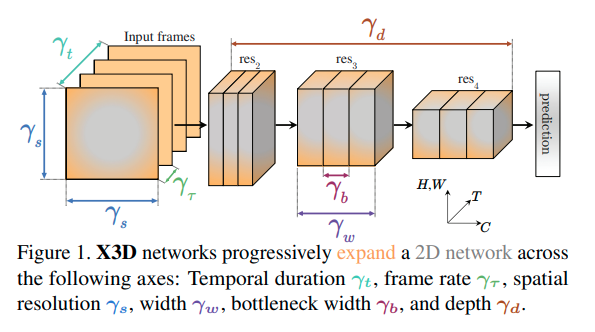

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

Code was inspired from the GutHub repo: https://github.com/facebookresearch/pytorchvideo/blob/main/pytorchvideo/models/x3d.py

#### Network Building and HyperTuning of Parameters

In [28]:
# Squeeze-and-Excitation (SE) Block
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = keras.layers.GlobalAveragePooling3D()(input_tensor)
    se = keras.layers.Dense(filters // reduction, activation='relu')(se)
    se = keras.layers.Dense(filters, activation='sigmoid')(se)
    return keras.layers.Multiply()([input_tensor, se])

# X3D Stem Layer
def create_x3d_stem_tf(in_channels, out_channels, conv_kernel_size=(5, 3, 3), conv_stride=(1, 2, 2), norm=keras.layers.BatchNormalization, norm_eps=1e-5, norm_momentum=0.1):
    return keras.Sequential([
        keras.layers.Conv3D(filters=out_channels, kernel_size=(1, conv_kernel_size[1], conv_kernel_size[2]), 
                            strides=(1, conv_stride[1], conv_stride[2]), padding='same', use_bias=False, 
                            kernel_regularizer=keras.regularizers.l2(0.01)),
        norm(epsilon=norm_eps, momentum=norm_momentum),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.3),  # Reduced dropout rate
        keras.layers.Conv3D(filters=out_channels, kernel_size=(conv_kernel_size[0], 1, 1), 
                            strides=(conv_stride[0], 1, 1), padding='same', use_bias=False, groups=out_channels,
                            kernel_regularizer=keras.regularizers.l2(0.01)),
        norm(epsilon=norm_eps, momentum=norm_momentum),
        keras.layers.Activation('relu')
    ])

# X3D Residual Block with SE Integration
def create_x3d_res_block(in_channels, out_channels, kernel_size, stride, bottleneck=False, norm=keras.layers.BatchNormalization):
    def block(x):
        identity = x
        if in_channels != out_channels or stride != (1, 1, 1):
            identity = keras.layers.Conv3D(filters=out_channels, kernel_size=1, strides=stride, padding='same', 
                                           use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01))(identity)
            identity = norm(epsilon=1e-5)(identity)

        if bottleneck:
            x = keras.layers.Conv3D(filters=out_channels // 2, kernel_size=1, padding='same', use_bias=False, 
                                    kernel_regularizer=keras.regularizers.l2(0.01))(x)
            x = norm(epsilon=1e-5)(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.Dropout(0.3)(x)

        x = keras.layers.Conv3D(filters=out_channels // (2 if bottleneck else 1), kernel_size=kernel_size, 
                                strides=stride, padding='same', use_bias=False, kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = norm(epsilon=1e-5)(x)
        x = keras.layers.Activation('relu')(x)

        if bottleneck:
            x = keras.layers.Conv3D(filters=out_channels, kernel_size=1, padding='same', use_bias=False, 
                                    kernel_regularizer=keras.regularizers.l2(0.01))(x)
            x = norm(epsilon=1e-5)(x)

        x = se_block(x)  # Add SE Block
        x = keras.layers.Add()([x, identity])
        return keras.layers.Activation('relu')(x)

    return block

In [29]:
# Model Definition
num_classes = len(LABELS)
input_shape = (None, SEQUENCE_LENGTH, HEIGHT, WIDTH, 3)
inputs = tf.keras.Input(shape=input_shape[1:])

stem = create_x3d_stem_tf(3, 32)(inputs)
stage_1 = create_x3d_res_block(16, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2))(stem)
stage_2 = create_x3d_res_block(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2))(stage_1)
stage_3 = create_x3d_res_block(64, 128, kernel_size=(3, 3, 3), stride=(1, 2, 2))(stage_2)
stage_4 = create_x3d_res_block(256, 512, kernel_size=(3, 3, 3), stride=(1, 2, 2), bottleneck=True)(stage_3)

gap = keras.layers.GlobalAveragePooling3D()(stage_4)

head = keras.layers.Dense(num_classes)(gap)

x3d_model = keras.Model(inputs=inputs, outputs=head)

In [33]:
lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=10000)

x3d_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])


In [34]:
frames, label = next(iter(train_ds))
x3d_model.build(frames)
x3d_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 20, 112,   │      1,280 │ input_layer[0][0] │
│ (Sequential)        │ 112, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 20, 56,    │     27,648 │ sequential[0][0]  │
│                     │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 56,    │        128 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 20, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │         96 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 20, 56,    │      1,024 │ sequential[0][0]  │
│                     │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 20, 56,    │          0 │ activation_2[0][… │
│                     │ 56, 32)           │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 56,    │        128 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 56,    │          0 │ multiply[0][0],   │
│                     │ 56, 32)           │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 20, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 56, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 20, 28,    │     55,296 │ activation_3[0][… │
│                     │ 28, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 28,    │        256 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 28, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 20, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 28, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_4[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,362,772 (9.01 MB)

 Trainable params: 2,358,676 (9.00 MB)

 Non-trainable params: 4,096 (16.00 KB)

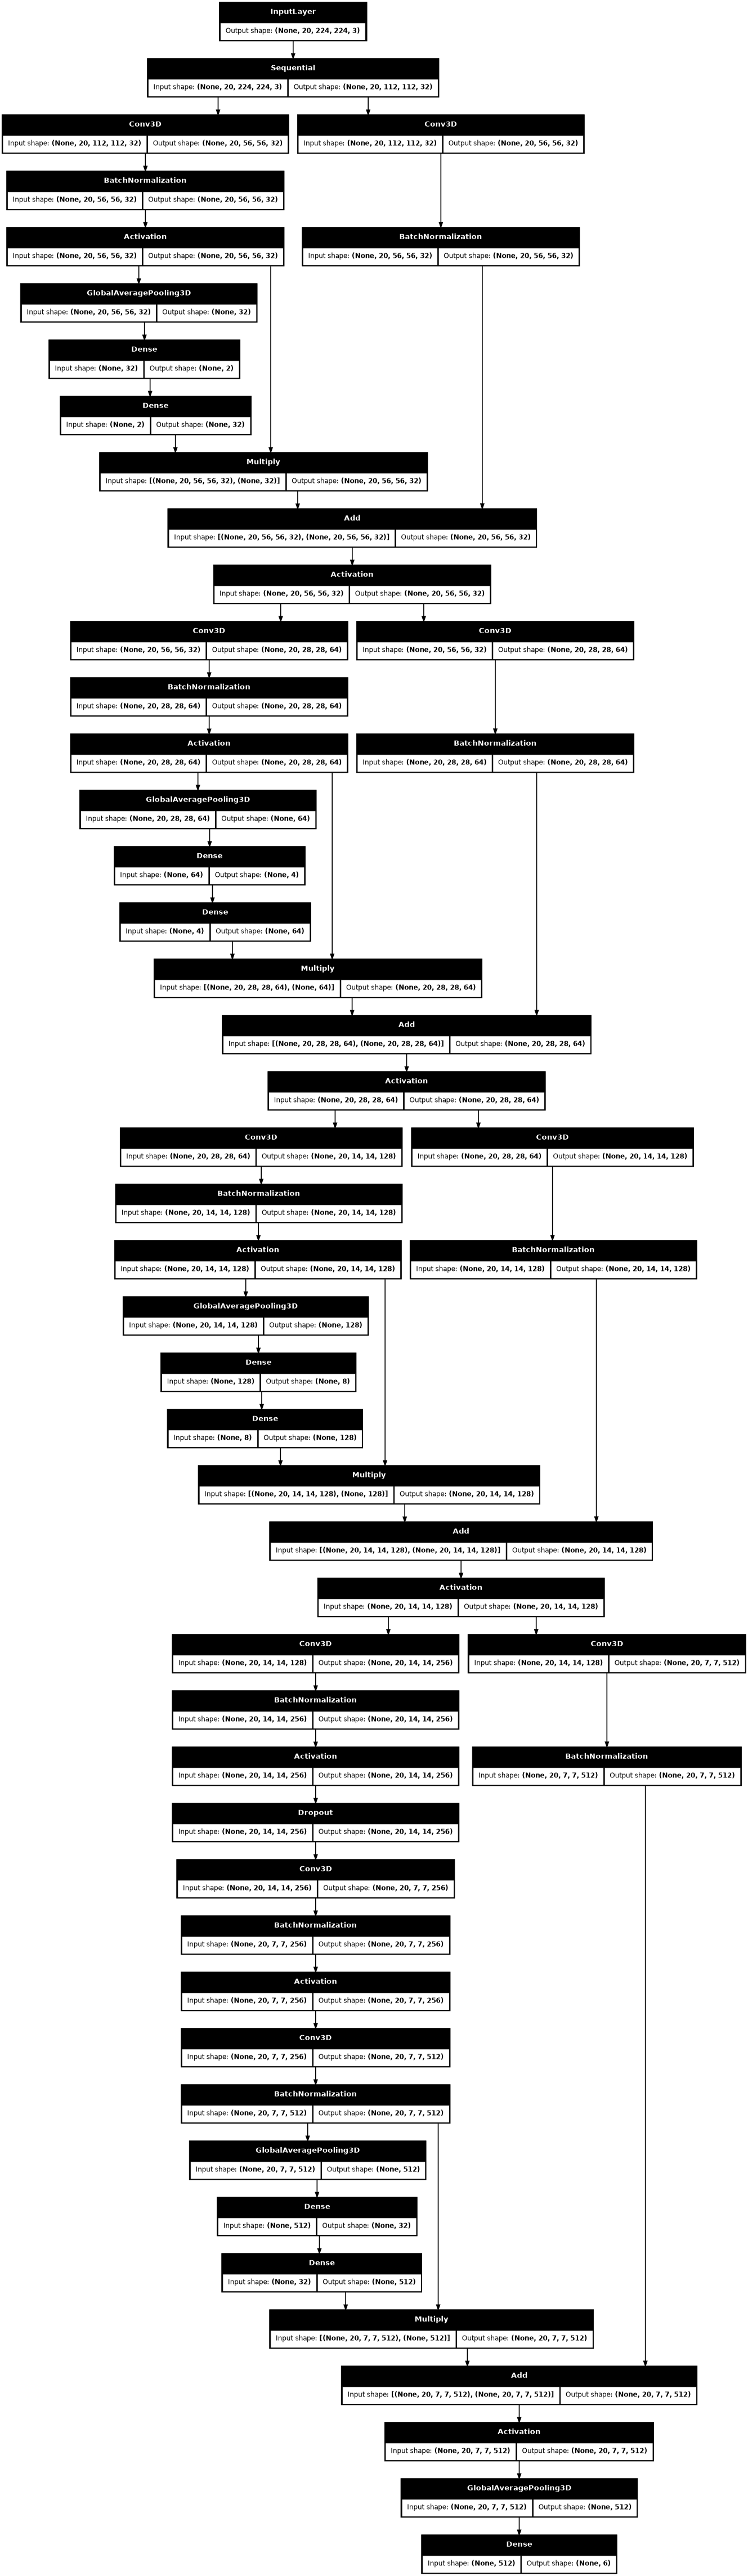

In [35]:
# Visualize the model
keras.utils.plot_model(x3d_model, expand_nested=True, dpi=60, show_shapes=True)

#### Train the model

In [ ]:
# Create a callback that saves the model's weights while training

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',        
        patience=30,                
        min_delta=1e-4,            
        restore_best_weights=True
        ),
    keras.callbacks.ModelCheckpoint(
        filepath='model_X3D.keras',       
        save_weights_only=False,           
        save_best_only=True,                
        monitor='val_accuracy',                 
        mode='max'
        ),
]

In [37]:
start_time = time.time()

history_1 = x3d_model.fit(x = train_ds,
                    epochs = 300, # You can change this if you want, ikaw bahala
                    callbacks=callbacks,
                    validation_data = val_ds)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Total training time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds")

Epoch 1/300


I0000 00:00:1733884105.556991   90417 service.cc:148] XLA service 0x7f9cd012f220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733884105.557219   90417 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-12-11 10:28:26.025761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733884106.980787   90417 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1733884119.648661   90417 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-11 10:28:39.895144: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[2,32,20,112,112]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,20,112,112]{4,3,2,1,0}, f32[32,1,5,1,1]{4,3,2,1,

      3/Unknown 27s 33ms/step - accuracy: 0.6111 - loss: 14.5799

2024-12-11 10:28:48.780086: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1733884128.818715   90417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    227/Unknown 35s 32ms/step - accuracy: 0.3060 - loss: 8.3923

2024-12-11 10:28:56.102763: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-11 10:28:56.102805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-12-11 10:29:49.424395: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:29:49.424450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 91s 281ms/step - accuracy: 0.3066 - loss: 8.3681 - val_accuracy: 0.2188 - val_loss: 3.5684
Epoch 2/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4090 - loss: 2.6682

2024-12-11 10:30:00.236411: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-11 10:30:00.236459: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:30:00.236471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - accuracy: 0.4090 - loss: 2.6666 - val_accuracy: 0.1979 - val_loss: 3.0333
Epoch 3/300


2024-12-11 10:30:44.794612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:30:44.794662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 57s 252ms/step - accuracy: 0.4112 - loss: 2.1968 - val_accuracy: 0.2604 - val_loss: 2.5262
Epoch 4/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4164 - loss: 1.8531

2024-12-11 10:31:49.700955: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-11 10:31:49.700990: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:31:49.700998: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.4166 - loss: 1.8526 - val_accuracy: 0.1667 - val_loss: 3.6719
Epoch 5/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4768 - loss: 1.7532

2024-12-11 10:32:40.541249: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:32:40.541284: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - accuracy: 0.4766 - loss: 1.7535 - val_accuracy: 0.1979 - val_loss: 2.6861
Epoch 6/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4195 - loss: 1.7778

2024-12-11 10:33:35.836520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:33:35.836557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - accuracy: 0.4196 - loss: 1.7775 - val_accuracy: 0.1771 - val_loss: 2.6659
Epoch 7/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5086 - loss: 1.5854

2024-12-11 10:34:28.060297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:34:28.060332: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 57s 252ms/step - accuracy: 0.5082 - loss: 1.5859 - val_accuracy: 0.2083 - val_loss: 2.9168
Epoch 8/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4848 - loss: 1.6032

2024-12-11 10:35:25.213720: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-11 10:35:25.213754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:35:25.213762: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - accuracy: 0.4842 - loss: 1.6038 - val_accuracy: 0.2083 - val_loss: 2.4763
Epoch 9/300
228/228 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - accuracy: 0.4390 - loss: 1.5342 - val_accuracy: 0.2500 - val_loss: 2.5491
Epoch 10/300


2024-12-11 10:37:04.361255: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:37:04.361299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4801 - loss: 1.5730

2024-12-11 10:37:11.668304: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:37:11.668338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.4797 - loss: 1.5731 - val_accuracy: 0.2500 - val_loss: 2.3704
Epoch 11/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4461 - loss: 1.6094

2024-12-11 10:38:01.869491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:38:48.693853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:38:48.693906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - accuracy: 0.4461 - loss: 1.6089 - val_accuracy: 0.3021 - val_loss: 2.1570
Epoch 12/300
228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 230ms/step - accuracy: 0.4576 - loss: 1.5513 - val_accuracy: 0.2708 - val_loss: 2.3114
Epoch 13/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4348 - loss: 1.5224

2024-12-11 10:39:55.259053: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:39:55.259096: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - accuracy: 0.4350 - loss: 1.5221 - val_accuracy: 0.2396 - val_loss: 2.3776
Epoch 14/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4773 - loss: 1.4169

2024-12-11 10:40:43.858871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.4772 - loss: 1.4173 - val_accuracy: 0.2812 - val_loss: 2.1852
Epoch 15/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8117 - loss: 1.1483

2024-12-11 10:41:24.064116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:41:24.064160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4878 - loss: 1.5066

2024-12-11 10:41:31.248281: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:41:31.248319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 208ms/step - accuracy: 0.4876 - loss: 1.5064 - val_accuracy: 0.2500 - val_loss: 2.4672
Epoch 16/300
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4425 - loss: 1.5247

2024-12-11 10:42:22.188684: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-11 10:42:22.188719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:42:22.188726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.4427 - loss: 1.5244 - val_accuracy: 0.2812 - val_loss: 2.2190
Epoch 17/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6783 - loss: 1.2560

2024-12-11 10:43:02.153067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:43:02.153109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4836 - loss: 1.3637

2024-12-11 10:43:09.328040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:43:09.328075: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step - accuracy: 0.4834 - loss: 1.3640 - val_accuracy: 0.3021 - val_loss: 2.2909
Epoch 18/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7533 - loss: 1.2344

2024-12-11 10:43:49.074969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5347 - loss: 1.3171

2024-12-11 10:43:56.170443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - accuracy: 0.5344 - loss: 1.3176 - val_accuracy: 0.3021 - val_loss: 2.1863
Epoch 19/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4604 - loss: 1.3702

2024-12-11 10:44:48.748807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:44:48.748859: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 49s 217ms/step - accuracy: 0.4606 - loss: 1.3699 - val_accuracy: 0.2396 - val_loss: 2.1263
Epoch 20/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7067 - loss: 0.6949

2024-12-11 10:45:30.661173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 48s 210ms/step - accuracy: 0.5186 - loss: 1.2969 - val_accuracy: 0.1875 - val_loss: 2.0983
Epoch 21/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.2733 - loss: 1.6117

2024-12-11 10:46:18.425161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4834 - loss: 1.3809

2024-12-11 10:46:29.150593: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:46:29.150627: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 225ms/step - accuracy: 0.4835 - loss: 1.3806 - val_accuracy: 0.2917 - val_loss: 2.0478
Epoch 22/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5238 - loss: 1.2835

2024-12-11 10:47:16.642159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:47:56.885359: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - accuracy: 0.5237 - loss: 1.2837 - val_accuracy: 0.3125 - val_loss: 2.3020
Epoch 23/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4824 - loss: 1.3651

2024-12-11 10:48:06.871040: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:48:06.871077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - accuracy: 0.4826 - loss: 1.3648 - val_accuracy: 0.2604 - val_loss: 2.2489
Epoch 24/300
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5467 - loss: 1.3085

2024-12-11 10:49:39.763129: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:49:39.763173: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.5466 - loss: 1.3086 - val_accuracy: 0.3229 - val_loss: 2.1895
Epoch 25/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5186 - loss: 1.2748

2024-12-11 10:49:50.047721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:49:50.047760: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 49s 214ms/step - accuracy: 0.5189 - loss: 1.2746 - val_accuracy: 0.2708 - val_loss: 2.2578
Epoch 26/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6733 - loss: 1.1996

2024-12-11 10:50:31.306060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - accuracy: 0.5862 - loss: 1.1318 - val_accuracy: 0.3229 - val_loss: 2.1698
Epoch 27/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5518 - loss: 1.2336

2024-12-11 10:51:29.721489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:51:29.721525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.5517 - loss: 1.2332 - val_accuracy: 0.3229 - val_loss: 2.1905
Epoch 28/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4921 - loss: 1.2544

2024-12-11 10:52:56.932287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:52:56.932342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - accuracy: 0.4923 - loss: 1.2540 - val_accuracy: 0.3333 - val_loss: 2.2054
Epoch 29/300
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5976 - loss: 1.1283

2024-12-11 10:53:10.507740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - accuracy: 0.5975 - loss: 1.1284 - val_accuracy: 0.2917 - val_loss: 2.8419
Epoch 30/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4667 - loss: 1.2296

2024-12-11 10:53:51.499570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:53:51.499612: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5517 - loss: 1.1447

2024-12-11 10:53:58.633869: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:53:58.633906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 49s 214ms/step - accuracy: 0.5518 - loss: 1.1447 - val_accuracy: 0.2917 - val_loss: 2.7451
Epoch 31/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4350 - loss: 1.1166

2024-12-11 10:54:40.207835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5109 - loss: 1.1484

2024-12-11 10:54:47.475419: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:54:47.475455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - accuracy: 0.5114 - loss: 1.1479 - val_accuracy: 0.2292 - val_loss: 3.2386
Epoch 32/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6233 - loss: 1.2102

2024-12-11 10:55:32.723977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:55:32.724026: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5710 - loss: 1.0435

2024-12-11 10:55:39.825380: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-11 10:55:39.825421: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:55:39.825431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step - accuracy: 0.5710 - loss: 1.0438 - val_accuracy: 0.2917 - val_loss: 2.2178
Epoch 33/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4550 - loss: 1.3606

2024-12-11 10:56:19.824669: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 208ms/step - accuracy: 0.5609 - loss: 1.0523 - val_accuracy: 0.3333 - val_loss: 2.1694
Epoch 34/300
228/228 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - accuracy: 0.5858 - loss: 1.0190 - val_accuracy: 0.3125 - val_loss: 2.3561
Epoch 35/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8567 - loss: 0.8599

2024-12-11 10:57:57.830934: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:57:57.830984: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6266 - loss: 1.0257

2024-12-11 10:58:04.979972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.6266 - loss: 1.0258 - val_accuracy: 0.3333 - val_loss: 2.3026
Epoch 36/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8067 - loss: 0.7585

2024-12-11 10:58:45.286841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6079 - loss: 1.0545

2024-12-11 10:58:52.380791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:58:52.380827: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 48s 213ms/step - accuracy: 0.6078 - loss: 1.0541 - val_accuracy: 0.3229 - val_loss: 2.5783
Epoch 37/300
  5/228 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9017 - loss: 0.6028

2024-12-11 10:59:33.569485: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:59:33.569535: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6346 - loss: 0.9118

2024-12-11 10:59:44.456118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 10:59:44.456154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702


228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.6347 - loss: 0.9122 - val_accuracy: 0.3021 - val_loss: 2.4875
Epoch 38/300
227/228 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6559 - loss: 0.9457

2024-12-11 11:00:33.578487: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703
2024-12-11 11:00:33.578523: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11097204034103592702
2024-12-11 11:01:13.594604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 219ms/step - accuracy: 0.6559 - loss: 0.9455 - val_accuracy: 0.3646 - val_loss: 2.2697
Total training time: 32 minutes and 54.86 seconds


- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

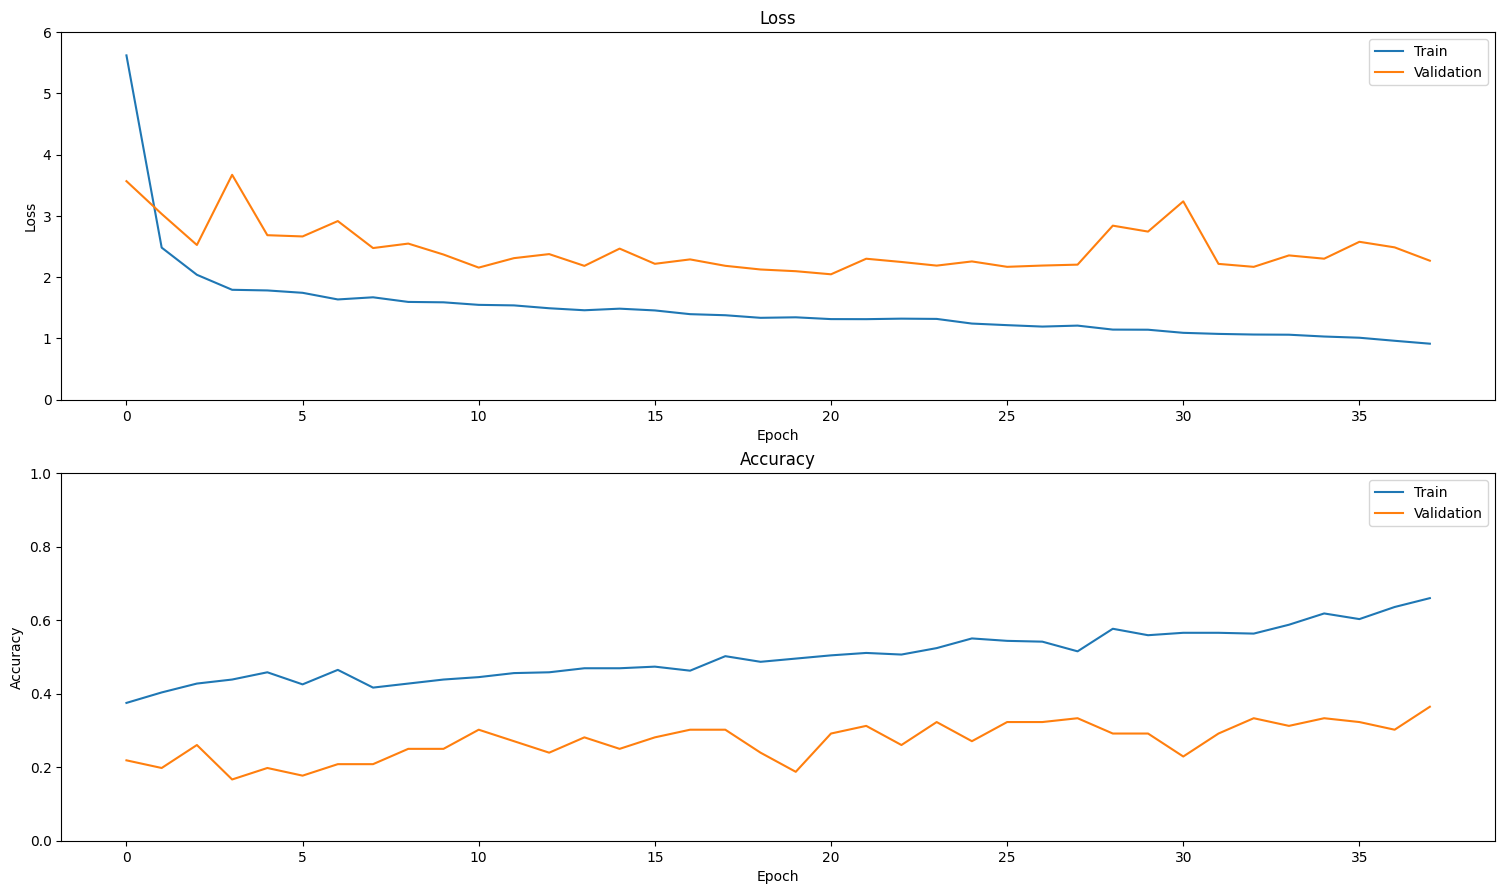

In [38]:
plot_history(history_1)

In [39]:
test_ds = configure_dataset(dataset_paths['test'], SEQUENCE_LENGTH, training=False)

# Create the training set
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validating set of frames: {test_frames.shape}')
print(f'Shape of validating labels: {test_labels.shape}')

Shape of validating set of frames: (2, 20, 224, 224, 3)
Shape of validating labels: (2,)


In [40]:
x3d_model.evaluate(test_ds, return_dict=True)

51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 830ms/step - accuracy: 0.4176 - loss: 1.9703


2024-12-11 11:17:50.431497: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1331248872012202703


{'accuracy': 0.3333333432674408, 'loss': 1.9924160242080688}

In [ ]:
fg = FrameGenerator(dataset_paths['train'], SEQUENCE_LENGTH, training=True)
labels = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds, x3d_model)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds, x3d_model)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall

## Load Model and Test

In [3]:
## Load model
load_model = keras.models.load_model('model_X3D.keras')

I0000 00:00:1734020379.693794   72641 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


#### Evaluate the Model

In [4]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

NameError: name 'get_actual_predicted_labels' is not defined

In [ ]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

In [ ]:
proba = load_model.predict(test_ds)

In [ ]:
MAP = calculate_map(actual, proba, len(labels))
MAP

In [ ]:
plot_precision_recall_curve(actual, proba, labels)

- Ganto si curve kasi may class imbalance, shhh muna wala pa matinong dataset :)

## Test the Model

#### 1 Window

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/OverheadPress.MOV'

cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=3),
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                                  )

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3.1, (0, 255, 0), 5, cv2.LINE_AA)

    cv2.imshow('Cam1', frame)

    # Perform prediction for every frames
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1], nasisira si cv2 pag wala HAHAHA
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### 2 Windowws

In [13]:
import cv2
import numpy as np
import mediapipe as mp

# MediaPipe setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Parameters
sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/OverheadPressBarbell.mp4'
save_dir = 'images/'  # Directory to save images
image_counter = 0  # Counter to generate unique filenames

# Video capture
cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""
pred_list = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Create a copy of the original frame before any modifications
    raw_frame = frame.copy()

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=3),
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
                                  )

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"{predicted_label}"
    cv2.putText(frame, display_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3.1, (0, 255, 0), 5, cv2.LINE_AA)

    # Stack the raw frame and processed frame horizontally
    combined = np.hstack((raw_frame, frame))
    cv2.imshow('Cam1', combined)

    # Perform prediction for every sequence_length frames and save the frame
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        pred_list.append(predicted_label)
        
        # Save the combined image
        save_path = f"{save_dir}frame_{image_counter:04d}.jpg"
        cv2.imwrite(save_path, combined)
        print(f"Saved image: {save_path}")
        image_counter += 1

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1734020546.120700   72641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734020546.134195  112433 gl_context.cc:357] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (NVIDIA GeForce RTX 3070)
W0000 00:00:1734020546.266170  112422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734020546.332800  112423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734020547.455636  112427 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1734020551.320693  111902 service.cc:148] XLA service 0x7fe91c005e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devic

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


I0000 00:00:1734020562.947532  111902 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Activity: Squat
Saved image: images/frame_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Activity: Squat
Saved image: images/frame_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Activity: Squat
Saved image: images/frame_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Activity: Squat
Saved image: images/frame_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: Squat
Saved image: images/frame_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
Saved image: images/frame_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
Saved image: images/frame_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: Squat
Saved image: images/frame_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Activity: Squat
Saved image: images/frame_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
Saved image: images/frame_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Activity: Squat
Saved image: images/frame_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: Squat
Saved

In [ ]:
set(pred_list)

- `Note:` You may notice that it really is inaccurate, this is because of the dataset, not the model's fault XD. No seriously, magulo talaga dataset namin, may mga videos na putol parts ng katawan kaya hindi masyado naje-generalize ng model.